# Your favorite word embedding

<font color='red'>
    <br>
Put in the cells below your favorite "vectorized word embedding" and submit your notebook in the lms (word embedding section before midnight Thursday the 3rd).
</font>

In [1]:
"""
(Practical tip) Table of contents can be compiled directly in jupyter notebooks using the following code:
I set an exception: if the package is in your installation you can import it otherwise you download it 
then import it.
"""
try:
    from jyquickhelper import add_notebook_menu 
except:
    !pip install jyquickhelper
    from jyquickhelper import add_notebook_menu
    
"""
Output Table of contents to navigate easily in the notebook. 
For interested readers, the package also includes Ipython magic commands to go back to this cell
wherever you are in the notebook to look for cells faster
"""
add_notebook_menu()

## Imports

In [2]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
import os
import pandas as pd
import numpy as np

In [4]:
from sklearn.preprocessing import OneHotEncoder

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Model
from keras.layers import Input, TextVectorization, Dense, Dropout, Flatten, Embedding

!pip install tensorflow-addons

import tensorflow_addons as tfa
from tensorflow_addons.metrics import F1Score

In [6]:
!pip install gensim
from gensim.test.utils import datapath
from gensim import utils
import gensim.models

## Dataset

In [7]:
TRAIN = pd.read_csv("http://www.i3s.unice.fr/~riveill/dataset/Amazon_Unlocked_Mobile/train.csv.gz")
VAL = pd.read_csv("http://www.i3s.unice.fr/~riveill/dataset/Amazon_Unlocked_Mobile/train.csv.gz")
TEST = pd.read_csv("http://www.i3s.unice.fr/~riveill/dataset/Amazon_Unlocked_Mobile/test.csv.gz")

In [8]:
''' Construct X_train and y_train '''
X_train = TRAIN['Reviews']
y_train = np.array(TRAIN['Rating']).reshape(-1,1)

X_val = VAL['Reviews']
y_val = np.array(VAL['Rating']).reshape(-1,1)

X_test = TEST['Reviews']
y_test = np.array(TEST['Rating']).reshape(-1,1)


ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
y_train_enc = ohe.fit_transform(y_train)
y_val_enc = ohe.fit_transform(y_val)
y_test_enc = ohe.fit_transform(y_test)

X_train.shape, y_train_enc.shape, np.unique(y_train)

((5000,), (5000, 5), array([1, 2, 3, 4, 5], dtype=int64))

## Word embedding and MLP classifier

### Constant definition


<font color='red'>
Use these constant names, you can of course change the value.
</font>

In [9]:
vocab_size = 100 # Vocab size
max_len = 100   # Sequence length to pad the outputs to.
embed_dim = 50 # embedding dimension
dense_dim = 128 # dense dimension
dropout_rate = 0.5 # Dropout rate
nb_classes = len(np.unique(y_train))

### Define Embedding Layer

<font color='red'>
$TO DO - Students$

* Define your embedding matrix or your vectorizer layer
    * --> if you choose Keras embedding -- vectorizer layr
    * --> if you choose Word2Vec, Glove or FastTex -- embedding matrix
    * --> if you choose gensim -- build you gensim model and then the embedding matrix
</font>

In [10]:
""" FILL """
from keras.layers import Input, TextVectorization, Dense, Flatten, Embedding
# Your code
vectorizer_layer = TextVectorization(max_tokens=max_len, output_sequence_length=max_len)
vectorizer_layer.adapt(X_train)
X_train_vec= vectorizer_layer(X_train)
X_test_vec = vectorizer_layer(X_test)
X_val_vec=vectorizer_layer(X_val)

### Build, fit and evaluate the network

<font color='red'>
$TO DO - Students$

Using your previous layer build a very simple MLP with:
* one hidden layer Dense + Dropout cells
    
print the summary of your model
</font>

### Using glove & embedding layers

In [11]:
# Build word dict
voc = vectorizer_layer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))
# word_index

In [12]:
# Make a dict mapping words (strings) to their NumPy vector representation:
path_to_glove_file = "glove.6B.50d.txt"

embeddings_index = {}
with open(path_to_glove_file,encoding="utf8") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [13]:
# num_tokens = len(voc) + 2
# embedding_dim = 50
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((max_len, embed_dim))
for word, i in word_index.items():
    print(word, i)
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

 0
[UNK] 1
the 2
i 3
it 4
and 5
phone 6
a 7
to 8
is 9
this 10
for 11
of 12
with 13
my 14
not 15
in 16
was 17
that 18
but 19
on 20
have 21
you 22
great 23
good 24
as 25
very 26
so 27
its 28
had 29
one 30
be 31
like 32
no 33
all 34
or 35
me 36
if 37
just 38
battery 39
use 40
has 41
screen 42
are 43
an 44
would 45
only 46
from 47
at 48
works 49
when 50
can 51
love 52
will 53
get 54
new 55
they 56
work 57
up 58
really 59
time 60
than 61
phones 62
dont 63
price 64
product 65
out 66
camera 67
im 68
am 69
about 70
because 71
buy 72
well 73
do 74
after 75
bought 76
sim 77
card 78
got 79
even 80
more 81
also 82
what 83
other 84
there 85
which 86
back 87
now 88
your 89
iphone 90
does 91
any 92
some 93
used 94
nice 95
excellent 96
fast 97
did 98
better 99
Converted 98 words (2 misses)


In [14]:
embedding_layer = Embedding(
    max_len,
    embed_dim,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

In [16]:
# define the model
""" FILL """
# define the model
input_ = Input(shape=(max_len,), dtype=tf.int32)
x = embedding_layer(input_)
x = Flatten()(x)
x = Dropout(rate=0.2)(x) #randomly select nodes to be dropped-out with given probability 0.2
output_ = Dense(5, activation='sigmoid')(x)
model = Model(input_, output_)
# summarize the model
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 50)           5000      
_________________________________________________________________
flatten_1 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dropout (Dropout)            (None, 5000)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 25005     
Total params: 30,005
Trainable params: 25,005
Non-trainable params: 5,000
_________________________________________________________________


<font color='Blue'>
* Compile the model with F1 score.
</font>

In [17]:
# compile the model
f1 = F1Score(num_classes=nb_classes, average="macro", threshold=0.5)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[f1])

<font color='blue'>
* Fit the modele using early stopping on f1_score
</font>

In [18]:
# fit model using ealy stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_f1_score', mode='max', patience=5, restore_best_weights=True, verbose=1)
history = model.fit(X_train_vec, y_train_enc,
                    validation_data=(X_val_vec, y_val_enc),
                    epochs=4000, callbacks=[es], verbose=1)

Epoch 1/4000
157/157 [==============================] - 4s 13ms/step - loss: 1.3869 - f1_score: 0.2459 - val_loss: 1.1351 - val_f1_score: 0.3049
Epoch 2/4000
157/157 [==============================] - 2s 10ms/step - loss: 1.1421 - f1_score: 0.3454 - val_loss: 1.0051 - val_f1_score: 0.4056
Epoch 3/4000
157/157 [==============================] - 2s 11ms/step - loss: 1.0354 - f1_score: 0.4236 - val_loss: 0.9168 - val_f1_score: 0.5276
Epoch 4/4000
157/157 [==============================] - 1s 8ms/step - loss: 0.9666 - f1_score: 0.4802 - val_loss: 0.8776 - val_f1_score: 0.5779
Epoch 5/4000
157/157 [==============================] - 1s 8ms/step - loss: 0.9146 - f1_score: 0.5179 - val_loss: 0.8176 - val_f1_score: 0.6010
Epoch 6/4000
157/157 [==============================] - 1s 8ms/step - loss: 0.8683 - f1_score: 0.5373 - val_loss: 0.7935 - val_f1_score: 0.5712
Epoch 7/4000
157/157 [==============================] - 1s 8ms/step - loss: 0.8359 - f1_score: 0.5687 - val_loss: 0.7587 - val_f1_sco

###  Comment
After fitting the model, the EarlyStopping function stops after a value of "val_f1_score" where it will no longer be decreasing 

<font color='blue'>
* Babysit your model
</font>

<AxesSubplot:>

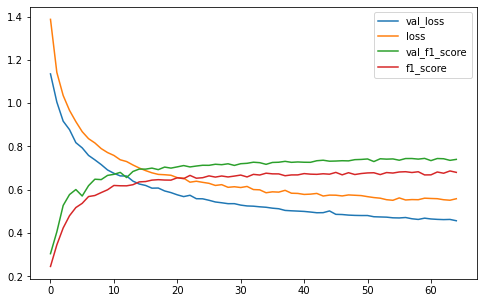

In [19]:
# Babysit the model
pd.DataFrame({'val_loss':history.history['val_loss'],
              'loss':history.history['loss'],
             'val_f1_score':history.history['val_f1_score'],
              'f1_score':history.history['f1_score']}).plot(figsize=(8,5))

<font color='blue'>
* Babysit your model
</font>

In [20]:
score = model.evaluate(X_val_vec, y_val_enc)
print('Test loss:', score[0])
print('Test f1_score', score[1])

157/157 [==============================] - 0s 2ms/step - loss: 0.4689 - f1_score: 0.7449
Test loss: 0.46890947222709656
Test f1_score 0.7449336051940918


In [21]:
# Evaluate the model
# f1.update_state(y_test_enc, model.predict(X_test))
# result = f1.result()
# result.numpy()

### Using vectorizer layers

In [30]:
from keras.layers import Input, Dense, Flatten, Embedding

In [22]:
# define the model
input_ = Input(shape=(vocab_size, ), name="input", dtype=tf.float32)
x = Dense(128, activation="relu", name="hidden")(input_)
x = Dropout(rate=0.2)(x)
output_ = Dense(5, activation='sigmoid', name="output")(x)
model1 = Model(input_, output_)
# summarize the model
model1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 100)]             0         
_________________________________________________________________
hidden (Dense)               (None, 128)               12928     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
output (Dense)               (None, 5)                 645       
Total params: 13,573
Trainable params: 13,573
Non-trainable params: 0
_________________________________________________________________


In [23]:
# compile the model
f1 = F1Score(num_classes=nb_classes, average="macro", threshold=0.5)
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[f1])

In [24]:
# fit model using ealy stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_f1_score', mode='max', patience=5, restore_best_weights=True, verbose=1)
history = model1.fit(X_train_vec, y_train_enc,
                    validation_data=(X_val_vec, y_val_enc),
                    epochs=4000, callbacks=[es], verbose=1)

Epoch 1/4000
157/157 [==============================] - 1s 4ms/step - loss: 6.6213 - f1_score: 0.2811 - val_loss: 2.8975 - val_f1_score: 0.3112
Epoch 2/4000
157/157 [==============================] - 0s 3ms/step - loss: 3.2992 - f1_score: 0.2987 - val_loss: 1.9174 - val_f1_score: 0.3316
Epoch 3/4000
157/157 [==============================] - 0s 3ms/step - loss: 2.2802 - f1_score: 0.3118 - val_loss: 1.4893 - val_f1_score: 0.3451
Epoch 4/4000
157/157 [==============================] - 0s 2ms/step - loss: 1.7067 - f1_score: 0.3282 - val_loss: 1.2769 - val_f1_score: 0.3472
Epoch 5/4000
157/157 [==============================] - 0s 3ms/step - loss: 1.4776 - f1_score: 0.3286 - val_loss: 1.1522 - val_f1_score: 0.3573
Epoch 6/4000
157/157 [==============================] - 1s 3ms/step - loss: 1.3040 - f1_score: 0.3380 - val_loss: 1.0748 - val_f1_score: 0.3625
Epoch 7/4000
157/157 [==============================] - 0s 3ms/step - loss: 1.2059 - f1_score: 0.3427 - val_loss: 1.0227 - val_f1_score:

In [25]:
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=[f1])

<AxesSubplot:>

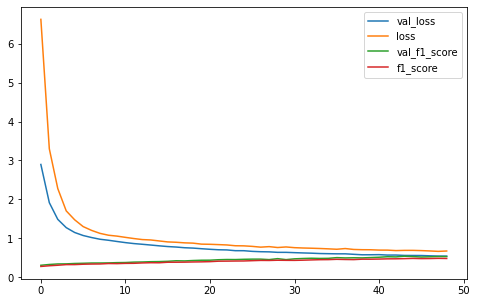

In [26]:
# Babysit the model
pd.DataFrame({'val_loss':history.history['val_loss'],
              'loss':history.history['loss'],
             'val_f1_score':history.history['val_f1_score'],
              'f1_score':history.history['f1_score']}).plot(figsize=(8,5))

In [27]:
score = model1.evaluate(X_val_vec, y_val_enc)
print('Test loss:', score[0])
print('Test f1_score', score[1])

157/157 [==============================] - 0s 1ms/step - loss: 0.5566 - f1_score: 0.5388
Test loss: 0.5565963983535767
Test f1_score 0.5387955904006958


## Conclusion :

 The word embedding model with glove performs better than the vectorizer layer  </br>


| Model | F1_score |
| --- | ----------- |
| only vectorizer layer  | 53.87 %|
| Embedding Matrix with glove| 74.49 %|